<a href="https://colab.research.google.com/github/b4435242/hardware-security/blob/main/dpa_hiding_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Break AES using DPA with correlations

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously


In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from google.colab import drive
from scipy.spatial.distance import hamming
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/Shared/hwb/lab03/SC_python_measurement')

In [35]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')


def hamming_distance_matrix(matrix1, matrix2):
    # ensure the two matrices have the same shape
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"

    # initialize the distance matrix
    distance_matrix = np.zeros(matrix1.shape)

    # iterate over the rows and columns of the matrices
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            # calculate the Hamming distance between the elements at the same position
            r = (1 << np.arange(8))[:,None]
            distance_matrix[i, j] = np.count_nonzero(matrix1[i, j]&r != matrix2[i, j]&r)

    return distance_matrix


# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

def trace_compression(traces, num):
  return scipy.signal.resample(traces, num, axis=1)
  
def trace_alignment(traces):
  first_trace = traces[0]
  lags = []
  for i, trace in enumerate(traces):
    cross_corr = scipy.signal.correlate(first_trace, trace)
    lag = np.argmax(cross_corr) - (trace.shape[0]+1)
    lags.append(lag)
  # Set traces aligned to the most left point
  most_left = min(lags)
  for i, trace in enumerate(traces):
    shift = lags[i] - most_left
    traces[i] = np.pad(trace[shift:], (0, shift), mode='constant') #shift and pad 0 at the end

  return traces

In [4]:
# read plaintext inputs
inputs = load_text("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/plaintext.txt")

# read length of one complete trace (number of samples per trace)
with open("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/traceLength.txt", "r") as fin:
  trace_length = int(fin.readline())

# trim each trace - select interesting part
start = 90000
len = 190000 # CHANGE to the length of the first round; 

# read traces from binary file
traces = np.fromfile("/content/drive/MyDrive/lab05_AES_hiding_time/hit3_1000_1ch/traces.bin", dtype='uint8') # read as linear array
traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
traces = traces[:, start:len] # select only the interesting part of each trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


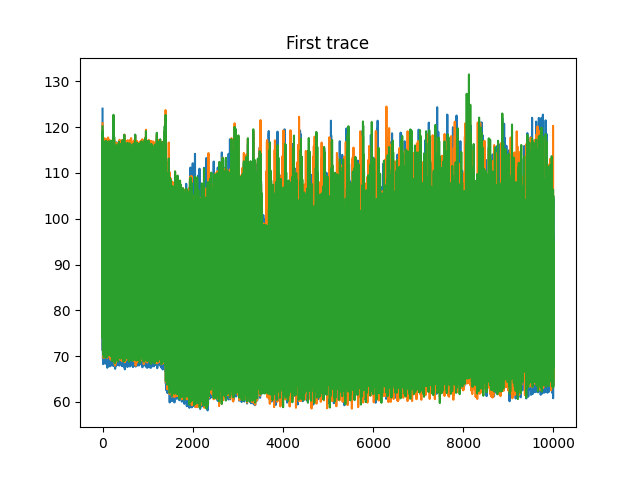

In [8]:
!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()
fig=plt.figure()
plt.plot(traces[[0, 99, 499]].T) # plotting a vector
plt.title("First trace")
plt.show()

In [6]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(traces.shape) # dimensions of matrix of traces

(1000, 16)
820000
(1000, 100000)


In [36]:
traces = trace_compression(traces, 10000)
print(traces.shape)
traces = trace_alignment(traces)
print(traces.shape)

(1000, 10000)
(1000, 10000)


In [ ]:
# If you feel brave enough -- interactive plots
#!pip install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
#%matplotlib widget

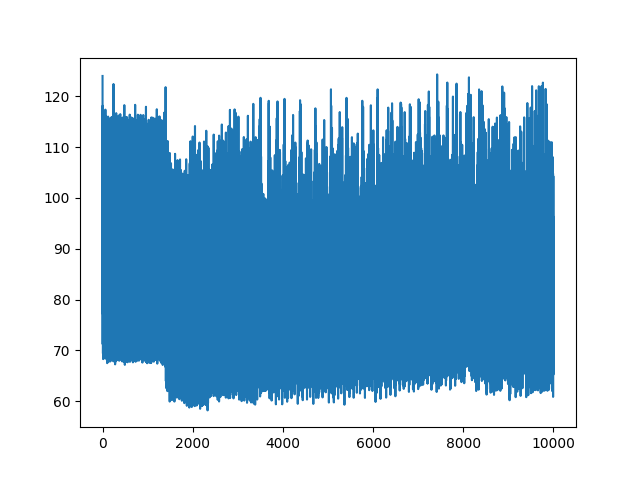

In [37]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[0])
plt.show()

## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [23]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys

In [24]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
# What is the shape of all the operands from the previous cell?
print(inputs.shape)
print(inp.shape)
print(inp[:, np.newaxis].shape)
print(keys.shape)
print(xmat.shape)
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [208  43 123 ... 111  98 135]
 [235 115  62 ...  93 246 144]
 [200 104  52 ... 154 124 187]]
(1000, 16)
(1000,)
(1000, 1)
(256,)
(1000, 256)
[[ 37  36  39 ... 216 219 218]
 [134 135 132 ... 123 120 121]
 [215 214 213 ...  42  41  40]
 ...
 [208 209 210 ...  45  46  47]
 [235 234 233 ...  22  21  20]
 [200 201 202 ...  53  54  55]]


In [25]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]

In [26]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
def power_model(model, smat, xmat):
  if model=="hw":
    return hw_table[smat]
  elif model=="hd":
    return hamming_distance_matrix(smat, xmat)
  else:
    return smat

[[6 4 4 ... 3 5 5]
 [2 4 6 ... 2 5 5]
 [3 6 2 ... 5 4 3]
 ...
 [3 5 5 ... 4 3 3]
 [5 4 4 ... 4 4 6]
 [4 6 4 ... 4 2 4]]
(1000, 256)
(1000, 10000)
max_acorr 0.253476
key: 165 time: 2378
key: ¥, a5


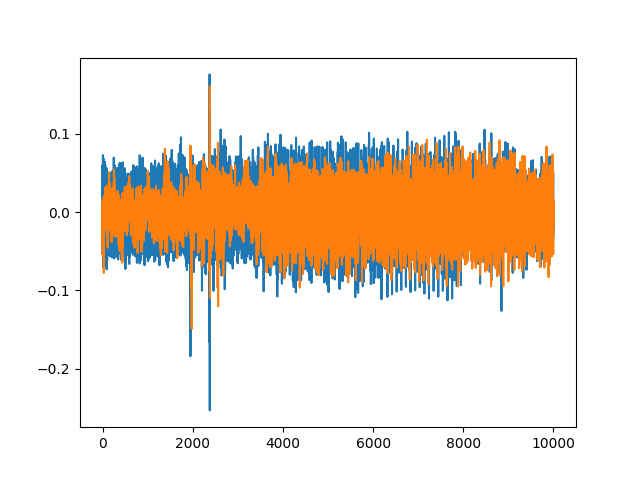

[[3. 2. 6. ... 5. 3. 4.]
 [3. 2. 6. ... 4. 3. 6.]
 [5. 1. 5. ... 6. 3. 3.]
 ...
 [2. 7. 5. ... 6. 5. 4.]
 [1. 5. 7. ... 3. 3. 6.]
 [1. 2. 6. ... 4. 4. 5.]]
(1000, 256)
(1000, 10000)
max_acorr 0.191792
key: 92 time: 1978
key: \, 5c


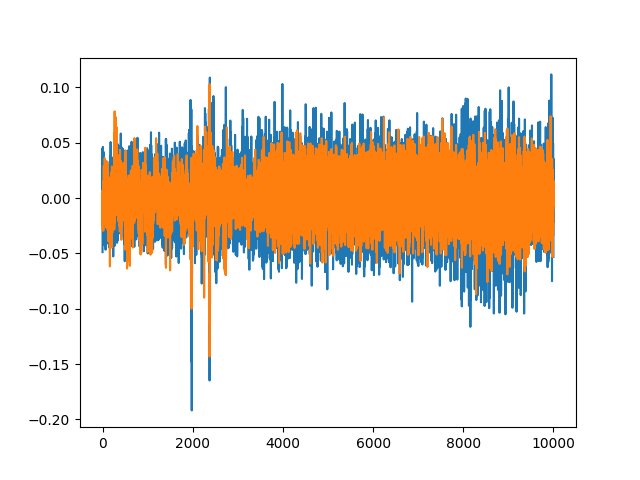

[[ 63  54 204 ...  97 185  87]
 [ 68  23  95 ...  33 188 182]
 [ 14 246   3 ... 229 165  52]
 ...
 [112  62 181 ... 216  49  21]
 [233 135  30 ...  71  89 250]
 [232 221 116 ... 150   5 154]]
(1000, 256)
(1000, 10000)
max_acorr 0.196872
key: 13 time: 1978
, 0d


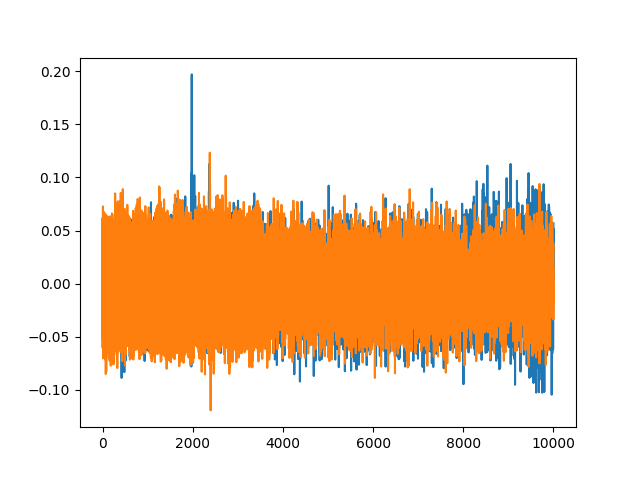

In [29]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
models = ["hw", "hd", "byte"]
for model in models:
  mat = power_model(model, smat, xmat)
  print(mat)
  print(mat.shape)
  print(traces.shape)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_acorr = acorr.max()
  (k, j) = np.where(acorr == max_acorr) # find idices of maximum
  print("max_acorr %f" % max_acorr)
  print("key: %d time: %d" % (k[0], j[0]))
  print("key: %1c, %02x" % (k[0], k[0]))
  # Plot the correlation traces for the right key byte guess and one wrong key byte guess
  # Do you see the correlation peaks?
  fig = plt.figure()
  plt.plot(corr[k[0]])
  plt.plot(corr[k[0]+1])
  plt.show()

## **Break all key bytes!**

In [28]:
def attack(inp, model):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_acorr = acorr.max()
  (k, j) = np.where(acorr == max_acorr) # find idices of maximum
  return k, j

In [30]:
print(inputs)

[[ 37 235 140 ...  71 237 252]
 [134  25 178 ... 142  50  68]
 [215 215 233 ...  61  22  57]
 ...
 [208  43 123 ... 111  98 135]
 [235 115  62 ...  93 246 144]
 [200 104  52 ... 154 124 187]]


In [31]:
models = ["hw", "hd", "byte"]
kk = np.zeros(16, dtype='uint8')
for model in models:
  for i in range(0, 16):
      inp = inputs[:, i]
      k, j = attack(inp, model)
      kk[i] = k[0]
      print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
  print(kk)

¥, a5 @ 2378
, 04 @ 2003

, 0a @ 2443
, 95 @ 2468
, 05 @ 2078
G, 47 @ 2528
, 8b @ 2558
B, 42 @ 2153
 , 00 @ 2618
, 97 @ 2203
L, 4c @ 2678
, 0e @ 2253
U, 55 @ 2738
W, 57 @ 2303
, 8d @ 2803
Á, c1 @ 2348
[165   4  10 149   5  71 139  66   0 151  76  14  85  87 141 193]
\, 5c @ 1978
, 9d @ 1998
p, 70 @ 2457
, 89 @ 2468
`, 60 @ 2078
f, 66 @ 2098
, 0e @ 2560
f, 66 @ 2588
, 0b @ 2178
ä, e4 @ 2648
©, a9 @ 2672
r, 72 @ 2702
H, 48 @ 2278
ñ, f1 @ 2762
|, 7c @ 2817
|, 7c @ 2822
[ 92 157 112 137  96 102  14 102  11 228 169 114  72 241 124 124]
, 0d @ 1978
, 1e @ 2413
, 17 @ 2028
h, 68 @ 2468
, 19 @ 2078
Ò, d2 @ 2533
, 17 @ 2128
, 84 @ 2583
 , 00 @ 2623
(, 28 @ 2653
¢, a2 @ 2678
÷, f7 @ 2727
, 18 @ 2738
À, c0 @ 2773
i, 69 @ 2817
, 83 @ 2366
[ 13  30  23 104  25 210  23 132   0  40 162 247  24 192 105 131]


## **Verify the key on a PT, CT pair!**

In [ ]:
key_bytes = bytes(kk)
outputs = ?

In [ ]:
# !pip install pycryptodome
from Crypto.Cipher import AES
cipher = AES.new(key_bytes, AES.MODE_ECB)
??

## **PGE**

In [ ]:
def PGE(inp, model, traces):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_corr_table = np.zeros(256)
  for i, corr_of_key in enumerate(acorr):
    max_corr_table[i] = corr_of_key.max()

  pge = max_corr_table.argsort()[::-1]
  return pge

  

In [ ]:
traces_num = [50, 100, 200, 499]
models = ["hw", "hd", "byte"]
kk = np.zeros(16, dtype='uint8')
for trace_num in traces_num:
  sub_traces = traces[:trace_num]
  sub_inputs = inputs[:trace_num]
  for model in models:
    for i in range(0, 16):
        inp = sub_inputs[:, i]
        pge = PGE(inp, model, sub_traces)
        print(pge)
      

[202   2  25   0 130 127 120 179 142  21 217  47 237 166 150  54 123 226
 133 208 199 113  55  14   7 172 164 210  66  10 247 206 238 225 248 103
  65 209  34  76 151 221  24  38 246  62 154  92   1  78 207 244 110 204
 230  97   3 107  32 148  96  35  48  75 108  56 198  72  17 193  46 249
  36  93  94 218  70 224   5  60 211  23 216 189  71 205 128  41 159  22
 124 175  74  81 197 163 147  80  43 252  67 222  99 240 167 171  73  98
 219  45 212 143  68 102  69 181 134 114 161 129 165  26 203 185 223  61
 232 101 239  30 201 144  95 169  18  91 231  88  27 119  29  39 215 106
  90 187 214 213  89 242 177 137 141 245 250  49 228  79  44 126 115 157
 121 135 105 109 188  28  11 190 118  64 146 241  85  13   6 152 195  63
  31 145 162  82 104  16  83 173  33 236 254 170 116 168 229 192 251  12
 186 253 125 194   8 131  42 117 235  53 112  77 196 139 158 122  37  58
 191 243 180 184  20   4 155 153 176 149 178  50  57   9 174 220  84 136
 233  87 234 138 183  52  19 132 111  51 140 255 16

KeyboardInterrupt: ignored